# Week 38 mBERT Binary 'Answerability' Classifier

In [8]:
import os
import polars as pl
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from bert_utils import (
    predict_binary,
    prepare_data,
    tokenize_function,
    train_mbert,
)

# Huggingface imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from datasets import load_dataset

In [9]:
# Select device for training
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
  device = torch.device("cuda")

print(f'Using device: {device}')

Using device: cpu


In [10]:
# Load dataset
dataset = load_dataset("coastalcph/tydi_xor_rc")
df_train = dataset["train"].to_polars()
df_val = dataset["validation"].to_polars()

# Arabic, Telegu and Korean
df_ar_train = df_train.filter(pl.col("lang") == "ar")
df_ar_val = df_val.filter(pl.col("lang") == "ar")
df_te_train = df_train.filter(pl.col("lang") == "te")
df_te_val = df_val.filter(pl.col("lang") == "te")
df_ko_train = df_train.filter(pl.col("lang") == "ko")
df_ko_val = df_val.filter(pl.col("lang") == "ko")

# Make a dict
data = {
    "arabic": {"train": df_ar_train, "val": df_ar_val},
    "telugu": {"train": df_te_train, "val": df_te_val},
    "korean": {"train": df_ko_train, "val": df_ko_val},
}

In [11]:
# Check Arabic distribution train
print(f"Arabic TRAINING set size: {len(df_ar_train)} with a total of {df_ar_train['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_ar_train['answerable'].sum() / len(df_ar_train) * 100:.2f}% answerable questions.")    
# Check Arabic distribution val
print(f"Arabic VALIDATION set size: {len(df_ar_val)} with a total of {df_ar_val['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_ar_val['answerable'].sum() / len(df_ar_val) * 100:.2f}% answerable questions.")

Arabic TRAINING set size: 2558 with a total of 2303 answerable questions.
This gives a distribution of 90.03% answerable questions.
Arabic VALIDATION set size: 415 with a total of 363 answerable questions.
This gives a distribution of 87.47% answerable questions.


In [12]:
# Check Telegu distribution train
print(f"Telegu TRAINING set size: {len(df_te_train)} with a total of {df_te_train['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_te_train['answerable'].sum() / len(df_te_train) * 100:.2f}% answerable questions.")    
# Check Telegu distribution val
print(f"Telegu VALIDATION set size: {len(df_te_val)} with a total of {df_te_val['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_te_val['answerable'].sum() / len(df_te_val) * 100:.2f}% answerable questions.")


Telegu TRAINING set size: 1355 with a total of 1310 answerable questions.
This gives a distribution of 96.68% answerable questions.
Telegu VALIDATION set size: 384 with a total of 291 answerable questions.
This gives a distribution of 75.78% answerable questions.


In [13]:
# Check Korean distribution train
print(f"Korean TRAINING set size: {len(df_ko_train)} with a total of {df_ko_train['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_ko_train['answerable'].sum() / len(df_ko_train) * 100:.2f}% answerable questions.")    
# Check Korean distribution val
print(f"Korean VALIDATION set size: {len(df_ko_val)} with a total of {df_ko_val['answerable'].sum()} answerable questions.")
print(f"This gives a distribution of {df_ko_val['answerable'].sum() / len(df_ko_val) * 100:.2f}% answerable questions.")

Korean TRAINING set size: 2422 with a total of 2359 answerable questions.
This gives a distribution of 97.40% answerable questions.
Korean VALIDATION set size: 356 with a total of 337 answerable questions.
This gives a distribution of 94.66% answerable questions.


In [14]:
# Get an average of answerable questions across all three languages and for both train and val
total_train_answerable = (
    df_ar_train['answerable'].sum() + 
    df_te_train['answerable'].sum() +
    df_ko_train['answerable'].sum() 
)
total_val_answerable = (
    df_ar_val['answerable'].sum() +
    df_te_val['answerable'].sum() +
    df_ko_val['answerable'].sum()
)

total_train_samples = (
    df_ar_train.height +
    df_te_train.height +
    df_ko_train.height 
)
total_val_samples = (
    df_ar_val.height +
    df_te_val.height +
    df_ko_val.height
)
total_answerable = total_train_answerable + total_val_answerable
total_samples = total_train_samples + total_val_samples
average_answerable = total_answerable / total_samples * 100
print(f"Average answerable questions across Arabic, Telegu and Korean: {average_answerable:.2f}% out of {total_samples} samples.")
print(f"Average answerable questions in TRAINING set: {total_train_answerable / total_train_samples * 100:.2f}% out of {total_train_samples} samples.")
print(f"Average answerable questions in VALIDATION set: {total_val_answerable / total_val_samples * 100:.2f}% out of {total_val_samples} samples.")

Average answerable questions across Arabic, Telegu and Korean: 92.96% out of 7490 samples.
Average answerable questions in TRAINING set: 94.27% out of 6335 samples.
Average answerable questions in VALIDATION set: 85.80% out of 1155 samples.


## Finetune the multilingual BERT for binary classification

In [15]:
mbert_checkpoint = "bert-base-multilingual-uncased"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)

In [16]:
### EXAMPLE OF DATA PROCESS PIPELINE
# Prepare datasets
# train_dataset = prepare_data(data["telugu"]["train"])
# # Tokenize datasets - fix the function call
# tokenized_train = train_dataset.map(lambda examples: tokenize_function(examples, mbert_tokenizer), batched=True)
# tokenized_train.features

In [17]:
all_classifiers = {}
all_tokenizers = {} # they're all the same
mbert_checkpoint = "bert-base-multilingual-uncased"
for lang in ["arabic", "telugu", "korean"]:
    cap_lang = lang.capitalize()
    print(f"\n--- Processing language: {cap_lang} ---")
    trained = False
    classifiers_dir = "./mbert_classifiers"
    save_path = f"{lang}_mbert_answerable_classifier"
    full_save_path = os.path.join(classifiers_dir, save_path)
    # Check if model exists
    if not os.path.exists(classifiers_dir):
        print(f"No classifiers folder found, creating {classifiers_dir}...")
        os.makedirs(classifiers_dir)
    if os.path.exists(full_save_path):
        print(f"Found existing model for {cap_lang}, loading...")
        all_classifiers[lang] = AutoModelForSequenceClassification.from_pretrained(full_save_path)
        all_tokenizers[lang] = AutoTokenizer.from_pretrained(full_save_path) # all the same, we don't train tokenizer
        trained = True
        print(f"Model for {cap_lang} loaded.")

    # If model doesn't exist, train it
    if not trained:
        print("Model not found, training new mBERT model...")
        mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)
        all_tokenizers[lang] = mbert_tokenizer # all the same, we don't train tokenizer
        mbert_classifier = AutoModelForSequenceClassification.from_pretrained(
            mbert_checkpoint,
            num_labels=2,
        )
        # Prepare datasets
        train_dataset = prepare_data(data[lang]["train"])
        val_dataset = prepare_data(data[lang]["val"])

        # Tokenize datasets - fix the function call
        tokenized_train = train_dataset.map(lambda examples: tokenize_function(examples, mbert_tokenizer), batched=True)
        tokenized_val = val_dataset.map(lambda examples: tokenize_function(examples, mbert_tokenizer), batched=True)
        # Train
        classifier, tokenizer = train_mbert(
            tokenized_train,
            tokenized_val,
            model_checkpoint = mbert_checkpoint,
            device=device,
        ) # type: ignore
        print("Saving model...")
        classifier.save_pretrained(full_save_path) # type: ignore
        tokenizer.save_pretrained(full_save_path) # type: ignore
        print(f"Model trained and saved to {full_save_path}.")
        # Store the trained model in notebook variable
        all_classifiers[lang] = AutoModelForSequenceClassification.from_pretrained(full_save_path)


--- Processing language: Arabic ---
Found existing model for Arabic, loading...
Model for Arabic loaded.

--- Processing language: Telugu ---
Found existing model for Telugu, loading...
Model for Telugu loaded.

--- Processing language: Korean ---
Found existing model for Korean, loading...
Model for Korean loaded.


## Compare pre-trained vs fine-tuned results

In [18]:
# Get pretrained model and tokenizer
pt_mbert = AutoModelForSequenceClassification.from_pretrained(
    mbert_checkpoint,
    num_labels=2,
)
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)


for lang in ["arabic", "telugu", "korean"]:
    # Test on a few examples BEFORE training
    print("=" * 50)
    print(f"{lang.upper()} BEFORE FINE-TUNING (Random Classification Head)")
    print("=" * 50)
    # Get a few examples from your validation set
    for i in range(3):
        example = data[lang]["val"].row(i, named=True)
        
        result = predict_binary(example["question"], example["context"], pt_mbert, mbert_tokenizer)
        
        print(f"\nExample {i+1}:")
        print(f"Question: {example['question'][:100]}...")
        print(f"Ground Truth: {'Answerable' if example['answerable'] else 'Not Answerable'}")
        print(f"Prediction: {'Answerable' if result['prediction'] == 1 else 'Not Answerable'}")
        print(f"Confidence: {result['confidence']:.3f}")
        print(f"Probs: [Not Answerable: {result['prob_class_0']:.3f}, Answerable: {result['prob_class_1']:.3f}]")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ARABIC BEFORE FINE-TUNING (Random Classification Head)

Example 1:
Question: ما هي أولى جامعات فنلندا؟...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.518
Probs: [Not Answerable: 0.482, Answerable: 0.518]

Example 2:
Question: ما عدد الدول المطلة على بحر البلطيق؟...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.528
Probs: [Not Answerable: 0.472, Answerable: 0.528]

Example 3:
Question: اين عاش نيوتن؟...
Ground Truth: Answerable
Prediction: Not Answerable
Confidence: 0.566
Probs: [Not Answerable: 0.566, Answerable: 0.434]
TELUGU BEFORE FINE-TUNING (Random Classification Head)

Example 1:
Question: ఒరెగాన్ రాష్ట్రంలోని అతిపెద్ద నగరం ఏది ?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.510
Probs: [Not Answerable: 0.490, Answerable: 0.510]

Example 2:
Question: కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.535
Probs: [Not Answerable: 0.465, Answerable: 0.535]

Example 3:
Questi

In [19]:
for lang in ["arabic", "telugu", "korean"]:
    # Test AFTER training on the same examples
    print("\n" + "=" * 50)
    print(f"{lang.upper()} AFTER FINE-TUNING")
    print("=" * 50)
    for i in range(3):
        example = data[lang]["val"].row(i, named=True)

        result = predict_binary(example['question'], example['context'], all_classifiers[lang], mbert_tokenizer)

        print(f"\nExample {i+1}:")
        print(f"Question: {example['question'][:100]}...")
        print(f"Ground Truth: {'Answerable' if example['answerable'] else 'Not Answerable'}")
        print(f"Prediction: {'Answerable' if result['prediction'] == 1 else 'Not Answerable'}")
        print(f"Confidence: {result['confidence']:.3f}")


ARABIC AFTER FINE-TUNING

Example 1:
Question: ما هي أولى جامعات فنلندا؟...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.999

Example 2:
Question: ما عدد الدول المطلة على بحر البلطيق؟...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.999

Example 3:
Question: اين عاش نيوتن؟...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.999

TELUGU AFTER FINE-TUNING

Example 1:
Question: ఒరెగాన్ రాష్ట్రంలోని అతిపెద్ద నగరం ఏది ?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.992

Example 2:
Question: కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.996

Example 3:
Question: కలరా వ్యాధిని మొదటగా ఏ దేశంలో కనుగొన్నారు ?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.705

KOREAN AFTER FINE-TUNING

Example 1:
Question: 북유럽의 노르딕 국가는 몇개인가요?...
Ground Truth: Answerable
Prediction: Answerable
Confidence: 0.999

Example 2:
Question: 1887년 케이스 웨스턴 리저브 대학의 이름은 무엇인가?...
G

In [20]:
# Get the global accuracy for each language on validation set  
for lang in ["arabic", "telugu", "korean"]:
    correct = 0
    total = len(data[lang]["val"])
    print(f"\nCalculating accuracy for {lang} on validation set of size {total}...")
    for i in range(total):
        example = data[lang]["val"].row(i, named=True)
        result = predict_binary(example['question'], example['context'], all_classifiers[lang], mbert_tokenizer)
        if result['prediction'] == example['answerable']:
            correct += 1
    accuracy = correct / total * 100
    print(f"Accuracy for {lang} on validation set: {accuracy:.2f}% ({correct}/{total})")


Calculating accuracy for arabic on validation set of size 415...
Accuracy for arabic on validation set: 98.07% (407/415)

Calculating accuracy for telugu on validation set of size 384...
Accuracy for telugu on validation set: 82.03% (315/384)

Calculating accuracy for korean on validation set of size 356...
Accuracy for korean on validation set: 96.63% (344/356)



Calculating confusion matrix for arabic on validation set of size 415...


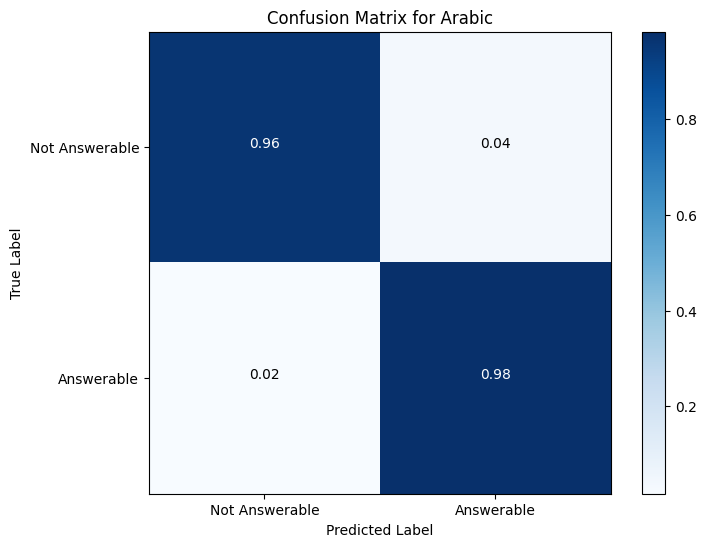

Classification Report for Arabic:
                precision    recall  f1-score   support

Not Answerable       0.89      0.96      0.93        52
    Answerable       0.99      0.98      0.99       363

      accuracy                           0.98       415
     macro avg       0.94      0.97      0.96       415
  weighted avg       0.98      0.98      0.98       415


Calculating confusion matrix for telugu on validation set of size 384...


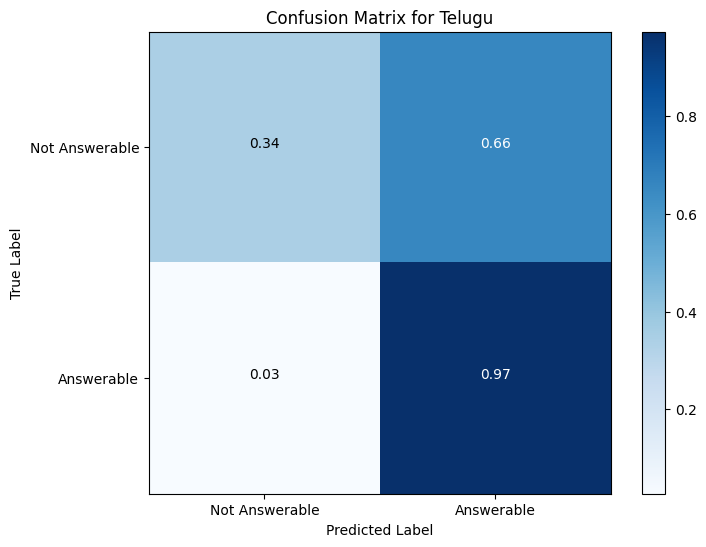

Classification Report for Telugu:
                precision    recall  f1-score   support

Not Answerable       0.80      0.34      0.48        93
    Answerable       0.82      0.97      0.89       291

      accuracy                           0.82       384
     macro avg       0.81      0.66      0.69       384
  weighted avg       0.82      0.82      0.79       384


Calculating confusion matrix for korean on validation set of size 356...


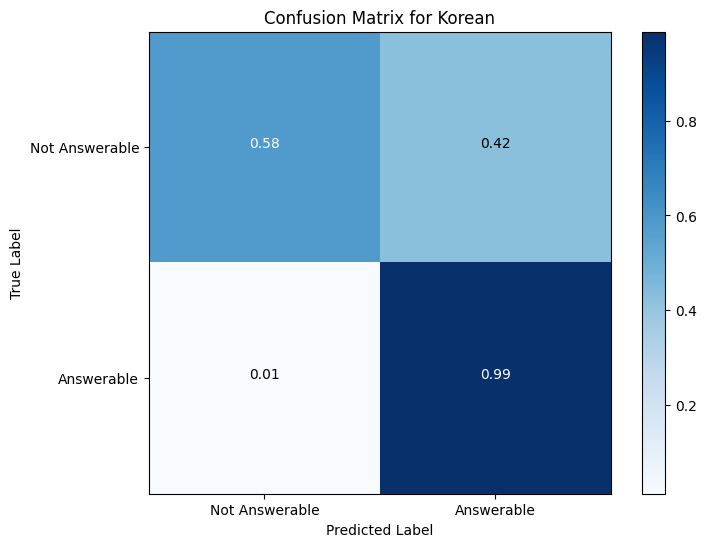

Classification Report for Korean:
                precision    recall  f1-score   support

Not Answerable       0.73      0.58      0.65        19
    Answerable       0.98      0.99      0.98       337

      accuracy                           0.97       356
     macro avg       0.85      0.78      0.81       356
  weighted avg       0.96      0.97      0.96       356



In [21]:
# Make confusion matrices for each language
for lang in ["arabic", "telugu", "korean"]:
    y_true = []
    y_pred = []
    total = len(data[lang]["val"])
    print(f"\nCalculating confusion matrix for {lang} on validation set of size {total}...")
    for i in range(total):
        example = data[lang]["val"].row(i, named=True)
        result = predict_binary(example['question'], example['context'], all_classifiers[lang], mbert_tokenizer)
        y_true.append(example['answerable'])
        y_pred.append(result['prediction'])
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {lang.capitalize()}")

    plt.colorbar()
    tick_marks = range(len(['Not Answerable', 'Answerable']))
    plt.xticks(tick_marks, ['Not Answerable', 'Answerable'])
    plt.yticks(tick_marks, ['Not Answerable', 'Answerable'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    # Include numbers as text in the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:.2f}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()
    print(f"Classification Report for {lang.capitalize()}:\n{classification_report(y_true, y_pred, target_names=['Not Answerable', 'Answerable'])}") 